# Data preprocessing for Chicago *Crime Rate* regression

Downloading health, airbnb rentals and crimes, and liquor store locations data snapshots for Chicago Community Areas shared by *GeoDa*.

In [368]:
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from constants import PREPROCESSED_DATA_PATH

health = gpd.read_file(geodatasets.get_path("geoda.chicago_health"))
airbnb_crime = gpd.read_file(geodatasets.get_path("geoda.airbnb"))
liquor_stores = gpd.read_file(geodatasets.get_path("geoda.liquor_stores"))

# Create a working GeoDataFrame
gdf = health.merge(airbnb_crime.drop('geometry', axis=1), on='community')

## Crime Rate calculation
In the following code block, the crime rate per unit of population is calculated. Using absolute crime numbers can be misleading as they don’t account for the population size of the community. For instance, a community with a larger population is likely to have a higher number of crimes simply because there are more people. By calculating the crime rate per unit of population, we normalize these numbers, making it possible to compare crime rates across communities of different sizes. In our analysis, we utilize the aggregated data of both violent crimes and property crimes available from `chicago_health` dataset.

<Axes: >

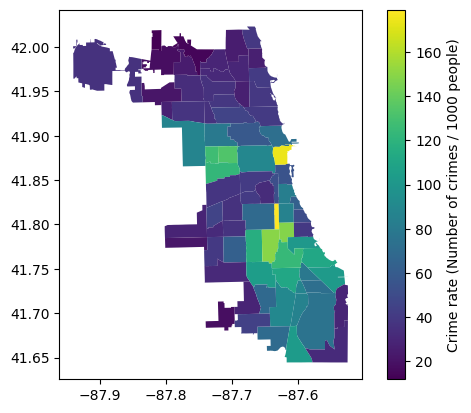

In [369]:
gdf['CRIME_RATE'] = (gdf['Property_C'] + gdf['Violent_C']) / gdf['Pop2014'] * 1000
gdf.plot('CRIME_RATE', legend=True, legend_kwds={"label": "Crime rate (Number of crimes / 1000 people)"})

## Population Density calculation
As part of the research, an evaluation will be performed to determine if the population density affects the crime rate in a community. The communities areas calculation are performed for ***NAD83 UTM Zone 16N*** CRS projection, which is one of the most commonly used for Chicago.

<Axes: >

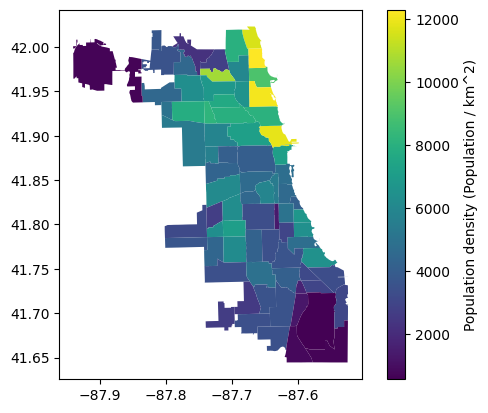

In [370]:
community_areas = gdf['geometry'].to_crs(epsg=26916).area / 10**6
gdf['POP_DENSITY'] = gdf['Pop2014'] / community_areas
gdf.plot('POP_DENSITY', legend=True, legend_kwds={"label": "Population density (Population / km^2)"})

## Liquor Stores Density calculation
Another focus of this analysis is to find out whether the availability of liquor stores for the population correlates with the crime rate. For this purpose, the *LIQUOR_STORES_DENSITY* coefficient is computed, which represents the number of liquor stores per 1000 people in the community.

<Axes: >

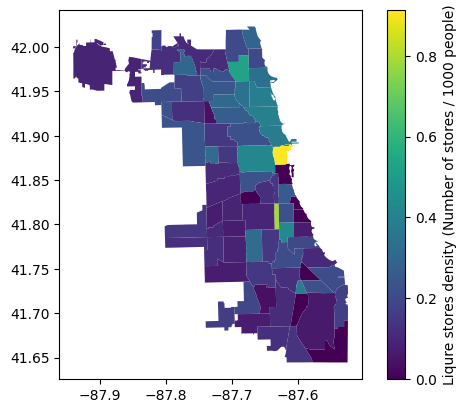

In [371]:
liquor_stores_in_health_crs = liquor_stores[['geometry']].to_crs(gdf.crs)

gdf = gdf.merge(
    gdf.sjoin(
        liquor_stores_in_health_crs
    ).groupby(
        'community'
    ).count().geometry.rename(
        'LIQUOR_STORES_NUMBER'
    ).reset_index(),
    how='left'
)
gdf['LIQUOR_STORES_NUMBER'].fillna(0, inplace=True)

gdf['LIQUOR_STORES_DENSITY'] = gdf['LIQUOR_STORES_NUMBER'] / gdf['Pop2014'] * 1000
gdf.plot('LIQUOR_STORES_DENSITY', legend=True, legend_kwds={"label": "Liqure stores density (Number of stores / 1000 people)"})

## Column selection
In this step, the selection of relevant columns for the regression analysis is made. Along with the attributes created in previous steps, some variables from the initial datasets will also be used. It could be interesting to analyze the following factors:

- Unemployment rate
- Percentage of people with income below 125% of the poverty line
- Per Capita Income
- Percentage of people over 65 and under 18 years of age
- Percentage of adults without higher education
- Percentage of the population that belongs to different racial groups

In [372]:
gdf = gdf[['community', 'geometry', 'CRIME_RATE', 'POP_DENSITY', 'LIQUOR_STORES_DENSITY', 'unemployed', 'Pov125P', 'PerCInc14',
           'Under18P', 'Over65P', 'without_hs', 'Wht14P', 'Blk14P', 'AS14P' ]]

gdf = gdf.rename(columns={
    'unemployed': 'UNEMPLOYED_PCT',
    'Pov125P': 'POP_BELOW_125_POVERTY_PCT',
    'Under18P': 'POP_UNDER_18_PCT',
    'Over65P': 'POP_OVER_65_PCT',
    'PerCInc14': 'PER_CAPITA_INCOME',
    'without_hs': 'ADULTS_WITHOUT_HS_PCT',
    'Wht14P': 'WHITE_POP_PCT',
    'Blk14P': 'BLACK_POP_PCT',
    'AS14P': 'ASIAN_POP_PCT',
})

Below are the charts for each of the independent variables, which have been extracted from the initial datasets. As we can observe from them, white communities in Chicago are predominantly located in the northern part of the city, while black communities are primarily situated in the southern region. This geographical distribution increases the representativeness of our dataset for analyzing the influence of race. Additionally, we note a small yet highly concentrated Asian community in Chinatown, enabling us to examine the impact of the Asian population percentage on the crime rate.

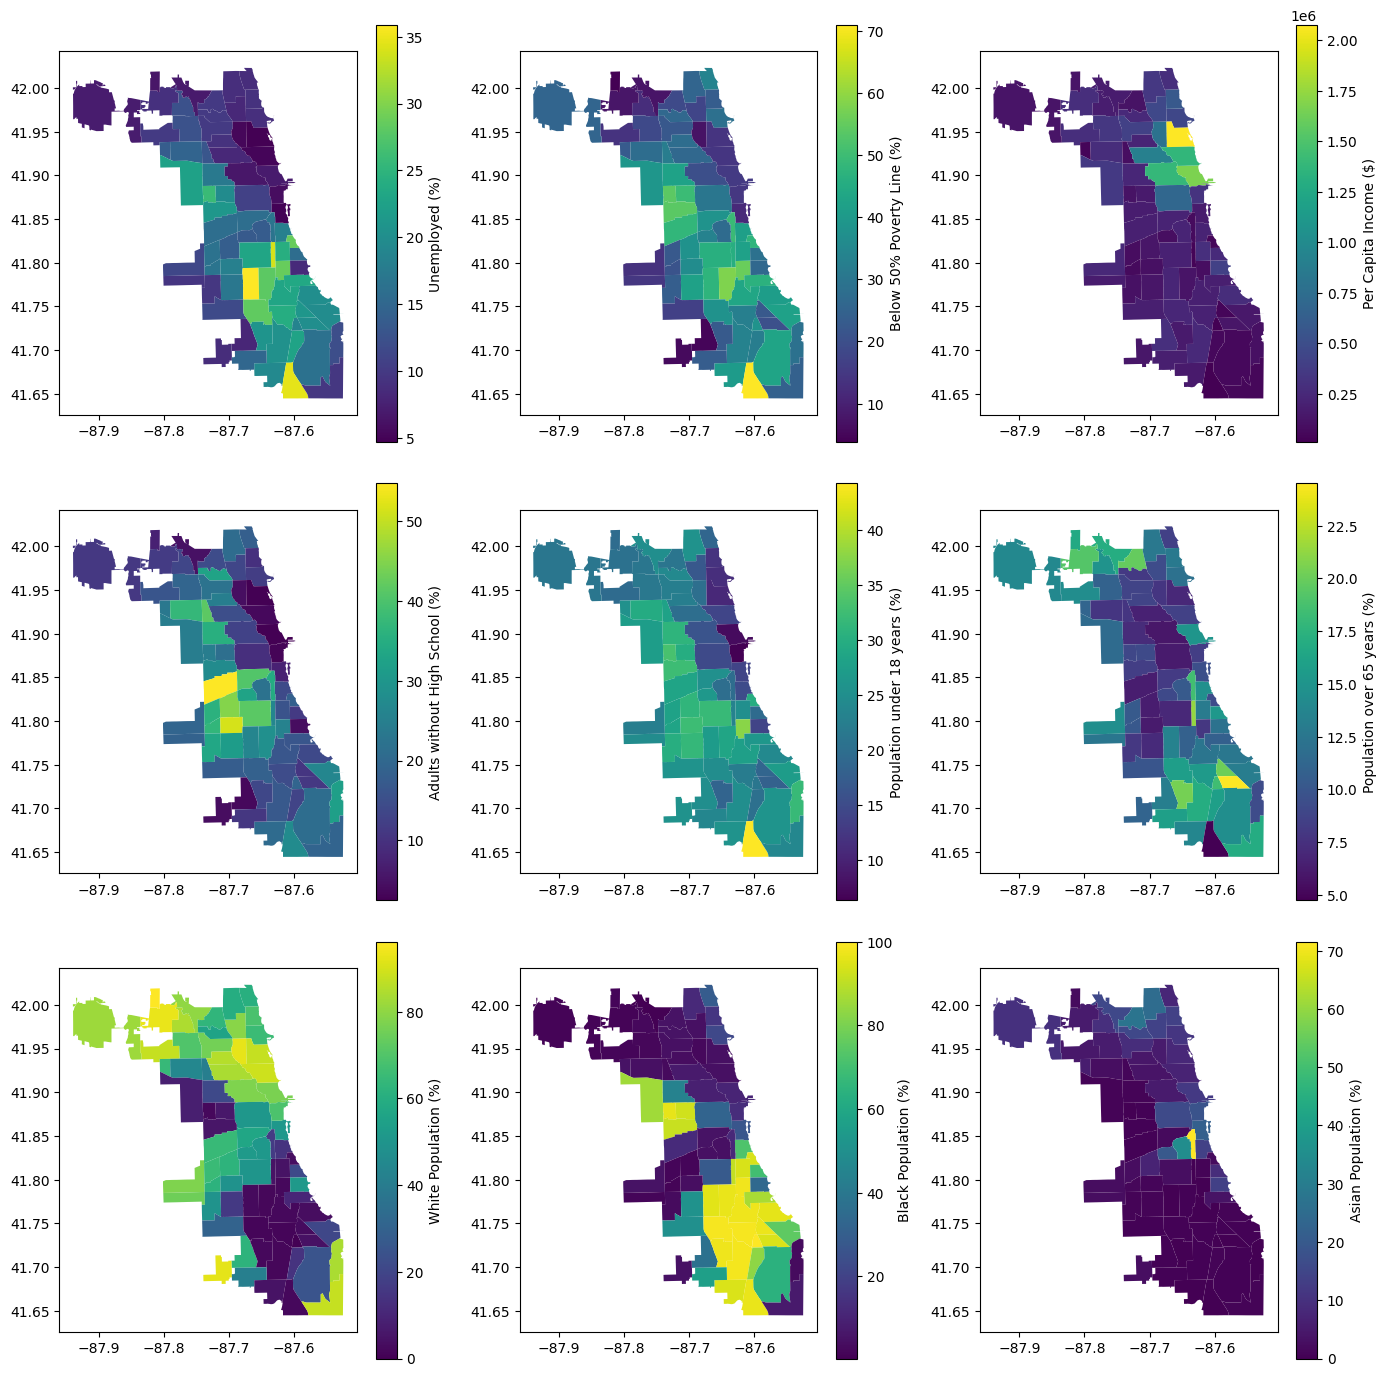

In [373]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14, 14))
ax = ax.ravel()

gdf.plot(column='UNEMPLOYED_PCT', ax=ax[0], legend=True, legend_kwds={"label": "Unemployed (%)"})
gdf.plot(column='POP_BELOW_125_POVERTY_PCT', ax=ax[1], legend=True, legend_kwds={"label": "Below 50% Poverty Line (%)"})
gdf.plot(column='PER_CAPITA_INCOME', ax=ax[2], legend=True, legend_kwds={"label": "Per Capita Income ($)"})
gdf.plot(column='ADULTS_WITHOUT_HS_PCT', ax=ax[3], legend=True, legend_kwds={"label": "Adults without High School (%)"})
gdf.plot(column='POP_UNDER_18_PCT', ax=ax[4], legend=True, legend_kwds={"label": "Population under 18 years (%)"})
gdf.plot(column='POP_OVER_65_PCT', ax=ax[5], legend=True, legend_kwds={"label": "Population over 65 years (%)"})
gdf.plot(column='WHITE_POP_PCT', ax=ax[6], legend=True, legend_kwds={"label": "White Population (%)"})
gdf.plot(column='BLACK_POP_PCT', ax=ax[7], legend=True, legend_kwds={"label": "Black Population (%)"})
gdf.plot(column='ASIAN_POP_PCT', ax=ax[8], legend=True, legend_kwds={"label": "Asian Population (%)"})

plt.tight_layout()
plt.show()

The correlation matrix provides a measure of how closely each pair of variables in the dataset are related. Each cell in the table shows the correlation coefficient between two variables.

In [374]:
Y_name = 'CRIME_RATE'
X_name = ['POP_DENSITY', 'LIQUOR_STORES_DENSITY', 'UNEMPLOYED_PCT', 'POP_BELOW_125_POVERTY_PCT', 'PER_CAPITA_INCOME', 'ADULTS_WITHOUT_HS_PCT',
          'POP_UNDER_18_PCT', 'POP_OVER_65_PCT', 'WHITE_POP_PCT', 'BLACK_POP_PCT', 'ASIAN_POP_PCT']

gdf[[Y_name] + X_name].corr()

,CRIME_RATE,POP_DENSITY,LIQUOR_STORES_DENSITY,UNEMPLOYED_PCT,POP_BELOW_125_POVERTY_PCT,PER_CAPITA_INCOME,ADULTS_WITHOUT_HS_PCT,POP_UNDER_18_PCT,POP_OVER_65_PCT,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT
CRIME_RATE,1.000000,-0.227678,0.392159,0.700903,0.650874,-0.126838,0.018069,0.170025,0.056253,-0.731024,0.766923,-0.221235
POP_DENSITY,-0.227678,1.000000,0.236110,-0.399021,-0.170521,0.605932,-0.017391,-0.406809,-0.400286,0.303594,-0.360382,0.232442
LIQUOR_STORES_DENSITY,0.392159,0.236110,1.000000,-0.054177,-0.053116,0.338411,-0.241865,-0.359737,-0.071636,0.125967,-0.030740,0.070817
UNEMPLOYED_PCT,0.700903,-0.399021,-0.054177,1.000000,0.794567,-0.433540,0.355474,0.569089,0.139356,-0.843398,0.806936,-0.327644
POP_BELOW_125_POVERTY_PCT,0.650874,-0.170521,-0.053116,0.794567,1.000000,-0.328463,0.535958,0.590121,-0.215214,-0.739277,0.632233,-0.124541
PER_CAPITA_INCOME,-0.126838,0.605932,0.338411,-0.433540,-0.328463,1.000000,-0.417764,-0.550721,-0.239349,0.389016,-0.271068,0.087756
ADULTS_WITHOUT_HS_PCT,0.018069,-0.017391,-0.241865,0.355474,0.535958,-0.417764,1.000000,0.671375,-0.390142,-0.183249,-0.080537,-0.086944
POP_UNDER_18_PCT,0.170025,-0.406809,-0.359737,0.569089,0.590121,-0.550721,0.671375,1.000000,-0.308920,-0.377107,0.270095,-0.380438
POP_OVER_65_PCT,0.056253,-0.400286,-0.071636,0.139356,-0.215214,-0.239349,-0.390142,-0.308920,1.000000,-0.215123,0.298536,0.098715
WHITE_POP_PCT,-0.731024,0.303594,0.125967,-0.843398,-0.739277,0.389016,-0.183249,-0.377107,-0.215123,1.000000,-0.921395,0.193339


To simplify our model and improve interpretability, we’re removing the variables with low correlation with the dependent variable: *ADULTS_WITHOUT_HS_PCT* (0.018069), *POP_UNDER_18_PCT* (0.170025), *PER_CAPITA_INCOME* (-0.126838), and *POP_OVER_65_PCT* (0.056253). These variables have weak relationships with the dependent variable, *CRIME_RATE*, and their exclusion can help reduce noise in the model.

Also, to avoid multicollinearity, we’re removing independent variables that are highly correlated with other independent variables. For instance, *UNEMPLOYED_PCT* is highly correlated with *POP_BELOW_125_POVERTY_PCT* (0.794567), *WHITE_POP_PCT* (-0.843398), and *BLACK_POP_PCT* (0.806936). High correlation between *WHITE_POP_PCT* and *BLACK_POP_PCT* (-0.921395) is a problem, which requires us to run each model separately for each of these races, to explore if the variables influence the dependent variable while avoiding multicollinearity.

The selection of variables has been adapted during the regression tests, keeping in mind that correlation does not imply causation.

In [375]:
gdf = gdf[['community', 'geometry', 'CRIME_RATE',
           'POP_DENSITY', 'LIQUOR_STORES_DENSITY', 'POP_BELOW_125_POVERTY_PCT', 'WHITE_POP_PCT', 'BLACK_POP_PCT', 'ASIAN_POP_PCT']]

gdf.to_file(PREPROCESSED_DATA_PATH, driver='GeoJSON')